### PROJECT OBJECTIVE
The project aims to develop a Diabetes Mellitus Prediction Model that will predict the likelihood of an individual developing diabetes based on key health indicators such as age, blood pressure, body mass index (BMI), glucose levels, and other medical features. Leveraging machine learning algorithms, this model will serve as a reliable tool for early detection of diabetes, enabling timely intervention and management. The model is trained on labeled datasets and employs performance metrics like accuracy and recall to ensure robust predictions.

### DATA DICTIONARY

- **Id:** Unique identifier for each data entry
- **Pregnancies:** Number of times the patient has been pregnant
- **Glucose:** Plasma glucose concentration over 2 hours in an oral glucose tolerance test
- **BloodPressure:** Diastolic blood pressure (mm Hg)
- **SkinThickness:** Triceps skinfold thickness (mm)
- **Insulin:** 2-Hour serum insulin (mu U/ml)
- **BMI:** Body mass index (weight in kg / height in m^2)
- **DiabetesPedigreeFunction:** Diabetes pedigree function, a genetic score of diabetes
- **Age:** Age in years
- **Outcome:** Binary classification indicating the presence (1) or absence (0) of diabetes

### IMPORT LIBRARIES

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import pickle
import streamlit as st
import operator

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load dataset
data = pd.read_csv('diabetes.csv')
data.head()

Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   
2   3            8      183             64              0        0  23.3   
3   4            1       89             66             23       94  28.1   
4   5            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

### DATA OVERVIEW/INSPECTION

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2768 non-null   int64  
 1   Pregnancies               2768 non-null   int64  
 2   Glucose                   2768 non-null   int64  
 3   BloodPressure             2768 non-null   int64  
 4   SkinThickness             2768 non-null   int64  
 5   Insulin                   2768 non-null   int64  
 6   BMI                       2768 non-null   float64
 7   DiabetesPedigreeFunction  2768 non-null   float64
 8   Age                       2768 non-null   int64  
 9   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 216.4 KB


In [8]:
#Data Stastistics
data.describe().T

count         mean         std     min      25%  \
Id                        2768.0  1384.500000  799.197097   1.000  692.750   
Pregnancies               2768.0     3.742775    3.323801   0.000    1.000   
Glucose                   2768.0   121.102601   32.036508   0.000   99.000   
BloodPressure             2768.0    69.134393   19.231438   0.000   62.000   
SkinThickness             2768.0    20.824422   16.059596   0.000    0.000   
Insulin                   2768.0    80.127890  112.301933   0.000    0.000   
BMI                       2768.0    32.137392    8.076127   0.000   27.300   
DiabetesPedigreeFunction  2768.0     0.471193    0.325669   0.078    0.244   
Age                       2768.0    33.132225   11.777230  21.000   24.000   
Outcome                   2768.0     0.343931    0.475104   0.000    0.000   

                               50%       75%      max  
Id                        1384.500  2076.250  2768.00  
Pregnancies                  3.000     6.000    17.00  
Glucose                    117.000   141.000   199.00  
BloodPressure               72.000    80.000   122.00  
SkinThickness               23.000    32.000   110.00  
Insulin                     37.000   130.000   846.00  
BMI                         32.200    36.625    80.60  
DiabetesPedigreeFunction     0.375     0.624     2.42  
Age                         29.000    40.000    81.00  
Outcome                      0.000     1.000     1.00

##### Observations

- The maximum pregnancies is 17.0, this is higher than expected and could be a data entry error or outlier.
- The minimum BMI is 0.0, which is significantly below the plausible range. This suggests a potential data entry error.
- The maximum BMI is 80, which exceeds the plausible upper limit, indicating the presence of an outlier or possibly data entry error.
- The minimum Glucose level is 0.0, which is also extremely lower than expected, especially for test done 2hours after oral glucose, suggesting 
  an inaccurate measurement or data entry error.
- The minimum value of 0.0  for both Insulin and Skin Thickness is also below the plausible range for these indices and may be considered as data entry error.

In [10]:
# Check for Missing values
data.isnull().sum()

Id                          0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

##### No missing value

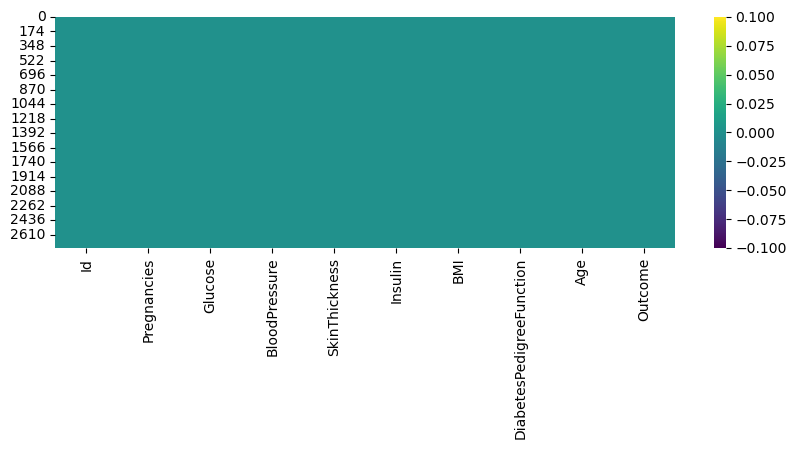

In [12]:
plt.figure(figsize=(10,3))
sns.heatmap(data.isnull(), cbar=True, cmap='viridis');

In [13]:
data.duplicated().sum()

0

##### No duplicates

In [15]:
data.head(3)

Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   
2   3            8      183             64              0        0  23.3   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1

### EXPLORATORY DATA ANALYSIS (EDA)

##### UNIVARIATE

In [18]:
data['Outcome'].value_counts()

Outcome
0    1816
1     952
Name: count, dtype: int64

<Axes: xlabel='Outcome', ylabel='Count'>

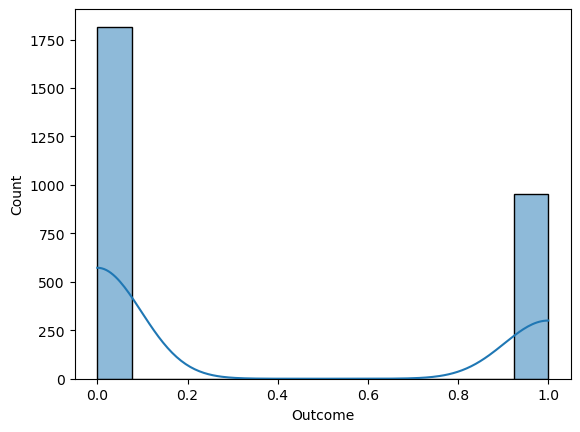

In [19]:
sns.histplot(data=data, x='Outcome', kde=True)

From the above histogram, most of the patients (about 1800) in the dataset did not have diabetes making the dataset imbalance.

Outcome
0    1816
1     952
Name: count, dtype: int64


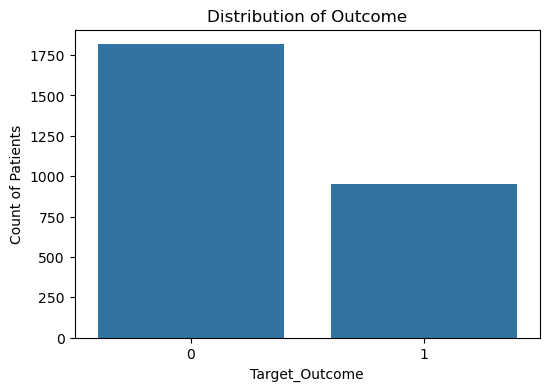

In [21]:
def label(Tg):
    if Tg == 1:
        return 'Yes'
    else:
        return 'No'
data['Target_Outcome'] = data['Outcome'].apply(label)
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=data)
plt.xlabel('Target_Outcome')
plt.ylabel('Count of Patients')
plt.title('Distribution of Outcome')
print(data['Outcome'].value_counts())

As observed from the histogram, the count plot showed most of the patients in the dataset did not have diabetes.

Target_Outcome
No     65.61
Yes    34.39
Name: count, dtype: float64


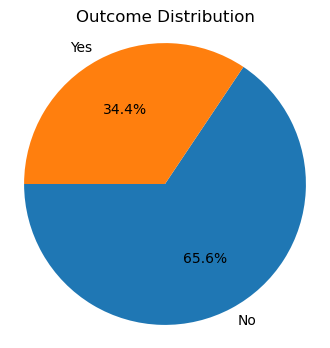

In [23]:
Outcome = round(data['Target_Outcome'].value_counts()/data.shape[0]*100,2)
print(Outcome)

# Plot pie chart for ratings distribution
plt.figure(figsize=(4,4))
plt.pie(Outcome, labels=Outcome.index, autopct='%1.1f%%', startangle=180)
plt.title('Outcome Distribution')
plt.axis('equal')
plt.show()

Just above 1/3 (34.4%) have diabetes while 65.6% did not.

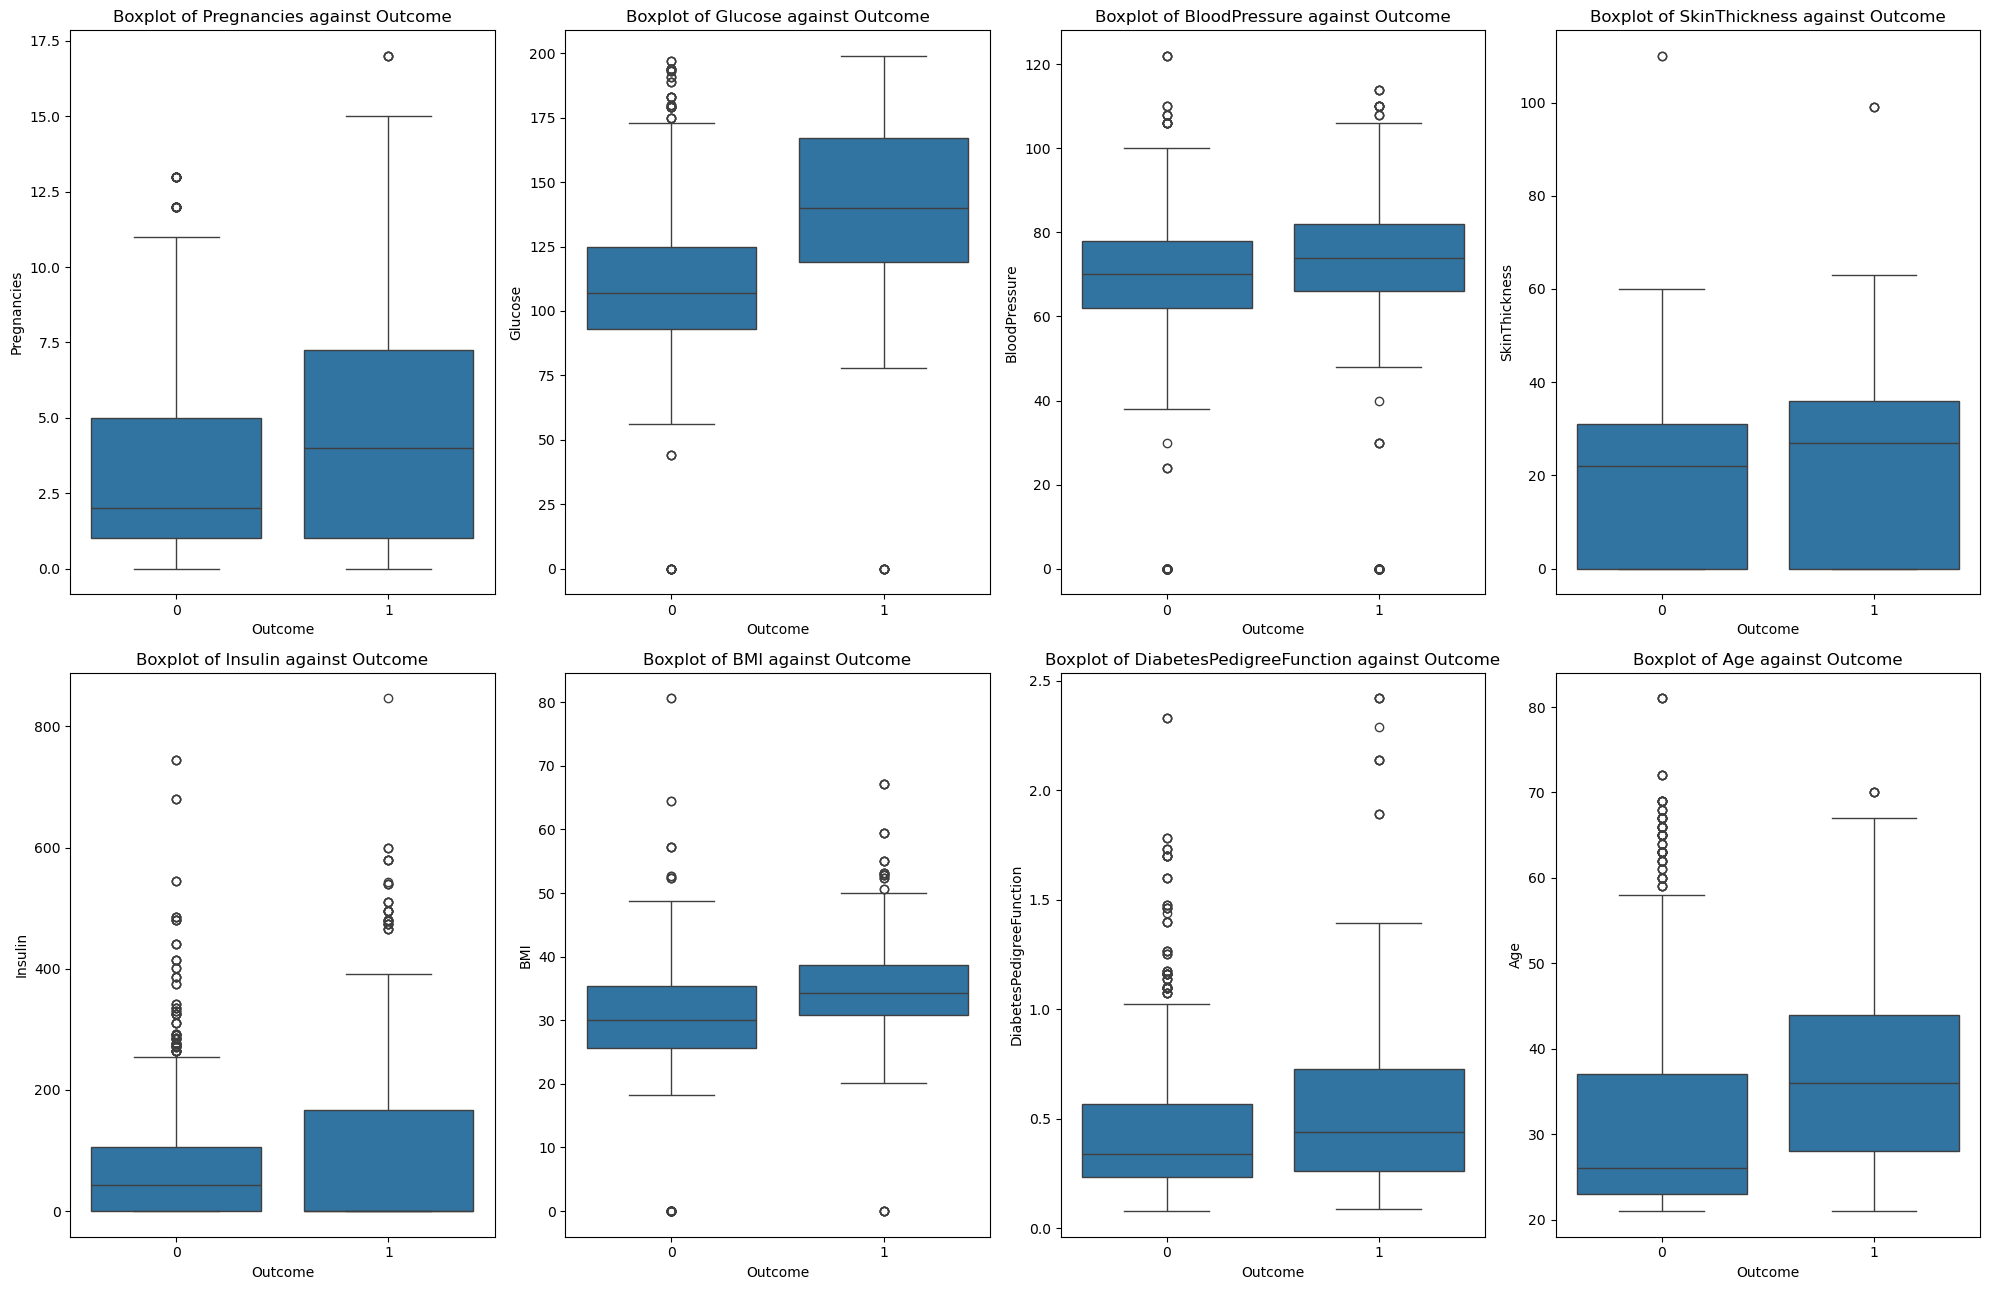

In [25]:
# Create subplots with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 13))

# List of features to plot
selected_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Plot each feature in a separate subplot
for i, feature in enumerate(selected_features):
    row = i // 4  # Determine the row
    col = i % 4   # Determine the column
    sns.boxplot(x='Outcome', y=feature, data=data, ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {feature} against Outcome')

# Adjust layout
plt.tight_layout()
plt.show()

##### OBSERVATIONS
- **Pregnancies vs Outcome -** The median for Outcome 1 (diabetes) is higher than the Outcome 0 (no diabetes). So there is a potential association between an increased number of pregnacies 
    and likelihood of having diabetes. Outliers are present in both outcomes.

- **Glucose vs Outcome -** The median glucose level for Outcome 1 is notably higher than for Outcome 0. Individuals with median glucose level of around 110 and below are likely to be non 
   diabetic while those with median glucose level higher than 140 are likely to be diabetic. There are both upper and lower outliers.

- **BloodPressure vs Outcome -** The boxplots show that the median blood pressure for diabetic patients is slightly higher than nondiabetic patients. Both outcomes have outliers, but they 
   are more pronounced for outcome 1.

- **SkinThickness vs Outcome -** It can be observed from the boxplots, the median skin thickness is slightly higher for diabetic patients than nondiabetic patients. Therefore, skin thickness 
   can be an indicator of diabetes.

- **Insulin vs Outcome -** There is a notable difference in the insulin levels between the two outcomes, with outcome 1 showing a higher median and more variability. Those with Outcome 1 (diabetes) 
   have a broader range of insulin levels, with a higher median compared to those with Outcome 0. This suggests that elevated insulin levels or greater variability in insulin levels might be linked 
   to an increased risk of diabetes.

- **BMI vs Outcome -** The median BMI is slightly higher for outcome 1 compared to outcome 0.

- **DiabetesPedigreeFunction (DPF)-** DPF measures the probability of diabetes based on diabetes family history and patient's age. The boxplots show the Outcome 1 has higher median value 
   compare to Output 0. Therefor, patients with lower DPF are much less likely to have diabetes while the patients with higher DPF are much more likely to have diabetes.

- **Age vs Outcome -** The median age for outcome 1 is higher than for outcome 0, suggesting that older individuals are more associated with outcome 1. Also, Outcome 1 has a wider spread of ages, 
   while outcome 0 is more concentrated around the lower age ranges.

In [27]:
data['Age'].min()

21

In [28]:
data['Age'].max()

81

Text(0.5, 1.0, 'Age Group Distribution')

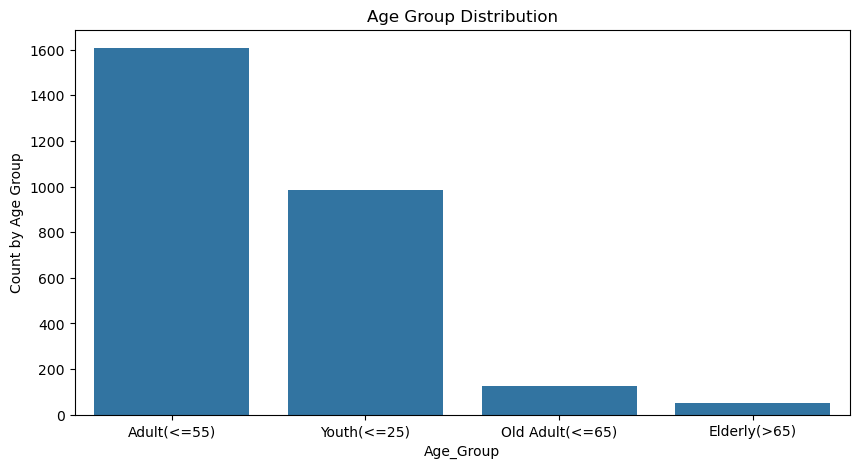

In [29]:
def Age_Group(Age):
    if Age <= 25:
        return 'Youth(<=25)'
    elif Age <= 55:
        return 'Adult(<=55)'
    elif Age <= 65:
        return 'Old Adult(<=65)'
    else:
        return 'Elderly(>65)'
data['Age_Group'] = data['Age'].apply(Age_Group)

# Patients Age Group Visualization
plt.figure(figsize=(10,5))
sns.countplot(x='Age_Group', data=data)
plt.xlabel('Age_Group')
plt.ylabel('Count by Age Group')
plt.title('Age Group Distribution')

High proportion of the patients in the dataset were of the age 55 and below

Text(0.5, 1.0, 'No of Pregnancies by Age_Group')

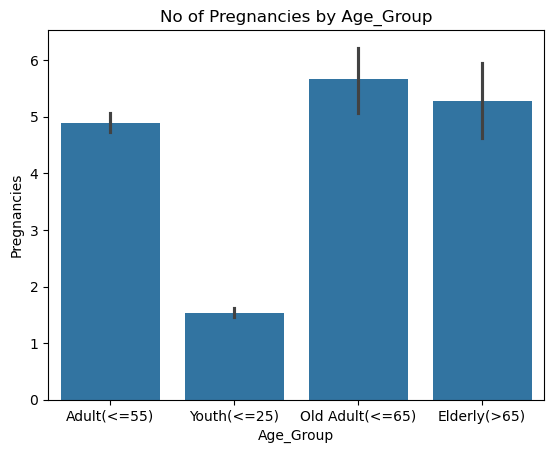

In [31]:
sns.barplot(x='Age_Group', y='Pregnancies', data=data)
plt.title('No of Pregnancies by Age_Group')

No of Pregnancies was around 5 for the Age_Group Adult(<=55), Old Adult(<=65) and Elderly(>65) while it is around 1 for the Youth(<=25)

Text(0.5, 1.0, 'Blood Pressure Distribution')

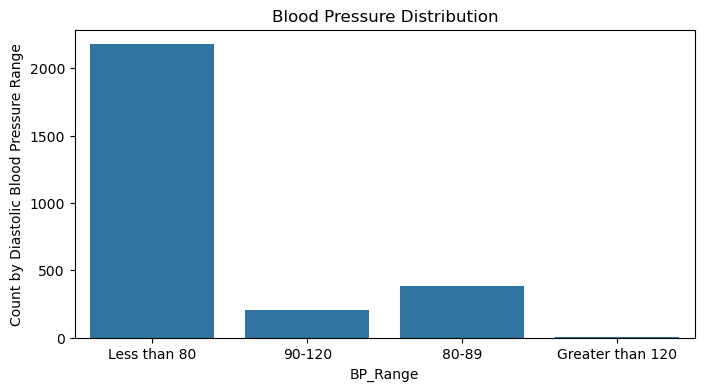

In [33]:
def BP_Range(BloodPressure):
    if BloodPressure <= 80:
        return 'Less than 80'
    elif 80 <= BloodPressure <= 89:
        return '80-89'
    elif 90 <= BloodPressure <= 120:
        return '90-120'
    else:
        return 'Greater than 120'

data['BP_Range'] = data['BloodPressure'].apply(BP_Range)

# Patients Age Group Visualization
plt.figure(figsize=(8,4))
sns.countplot(x='BP_Range', data=data)
plt.xlabel('BP_Range')
plt.ylabel('Count by Diastolic Blood Pressure Range')
plt.title('Blood Pressure Distribution')

Majority have blood pressure of less than 80

In [35]:
data.head(3)

Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   
2   3            8      183             64              0        0  23.3   

   DiabetesPedigreeFunction  Age  Outcome Target_Outcome    Age_Group  \
0                     0.627   50        1            Yes  Adult(<=55)   
1                     0.351   31        0             No  Adult(<=55)   
2                     0.672   32        1            Yes  Adult(<=55)   

       BP_Range  
0  Less than 80  
1  Less than 80  
2  Less than 80

<Axes: xlabel='BMI', ylabel='Count'>

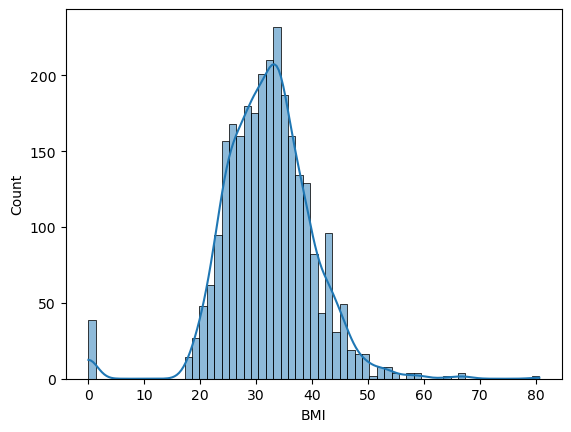

In [36]:
sns.histplot(data=data, x='BMI', kde=True)

- Unimodal distribution with peak 30.
- The chart skewed to the right.
- The value range from 0 80 most of the data between 20 and 40.

<Axes: xlabel='SkinThickness', ylabel='Count'>

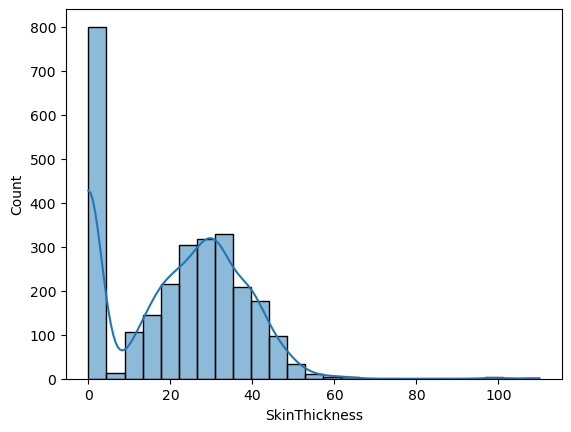

In [38]:
sns.histplot(data=data, x='SkinThickness', kde=True)

- Bimodal distribution, peaked at 0 and around 30.
- Right-skewed.
- Most data clustered between 20 and 40.

<Axes: xlabel='Glucose', ylabel='Count'>

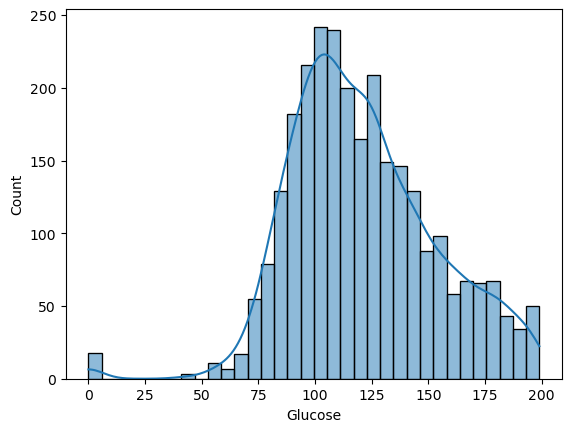

In [40]:
sns.histplot(data=data, x='Glucose', kde=True)

- The chart has unimodal distribution with a peak around 100.
- The chart is right-skewed.
- The range is between 0 and 200 with most data points between 70 150.

<Axes: xlabel='Insulin', ylabel='Count'>

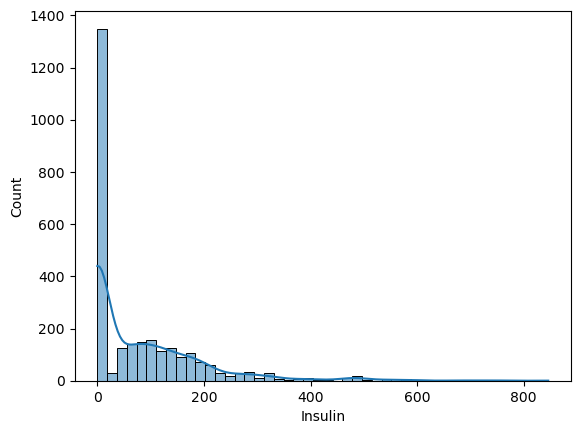

In [42]:
sns.histplot(data=data, x='Insulin', kde=True)

- Right-skewed distribution with most of the value concentrated around 0, indicating either most patiests have low insulin or data entry error or missinf values.
- There are outliers with some above 600.

##### BIVARIATE ANALYSIS

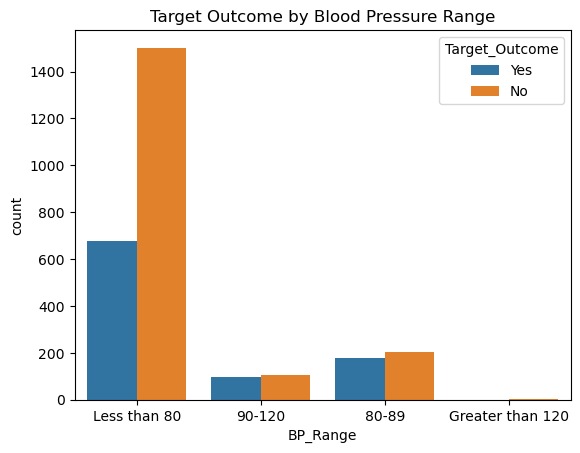

In [45]:
sns.countplot(x='BP_Range', hue='Target_Outcome', data=data)
plt.title('Target Outcome by Blood Pressure Range');

Across all the BP_Range, most patients did not have diabetes

##### MULTIVARIATE ANALYSIS

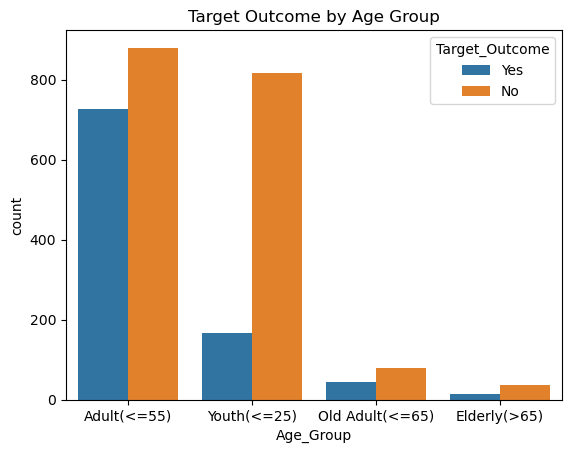

In [48]:
sns.countplot(x='Age_Group', hue='Target_Outcome', data=data)
plt.title('Target Outcome by Age Group');

Across all age groups, most patients did not have diabetes

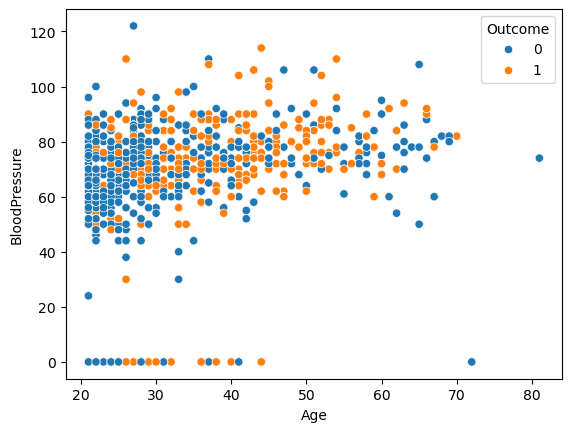

In [50]:
sns.scatterplot(x=data["Age"], y = data["BloodPressure"], hue = data["Outcome"]);

- Diabetic patients were spread across different age ranges and blood group with clustering between ages 30-60 and blood pressure around 60-90.
- Non-diabetic patients have cluster around age group 20-30 and blood pressure around 50 and 90.


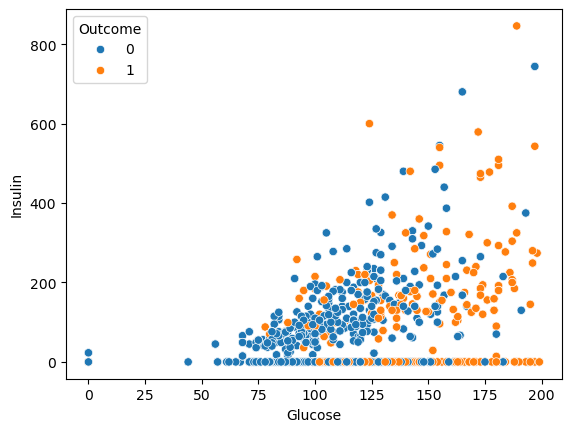

In [52]:
sns.scatterplot(x=data["Glucose"], y=data["Insulin"], hue=data["Outcome"]);

- Non-diabetic patients have a concentration between glucose values of 75-150 and insulin values of
  0-250.
- Diabetic patients clustered around glucose level above 125 and insulin value around 100 and 300.


<Axes: xlabel='BMI', ylabel='Age'>

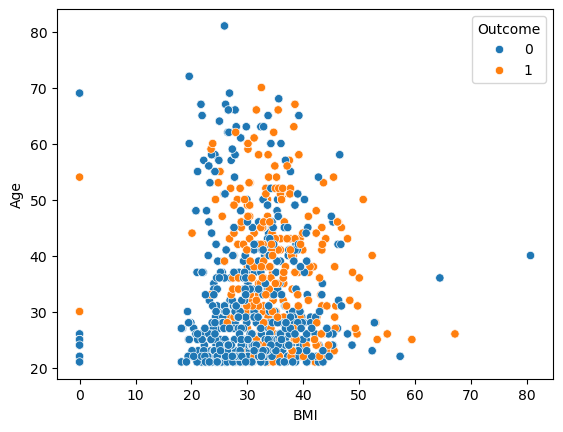

In [54]:
sns.scatterplot(x=data["BMI"], y=data["Age"], hue=data["Outcome"])

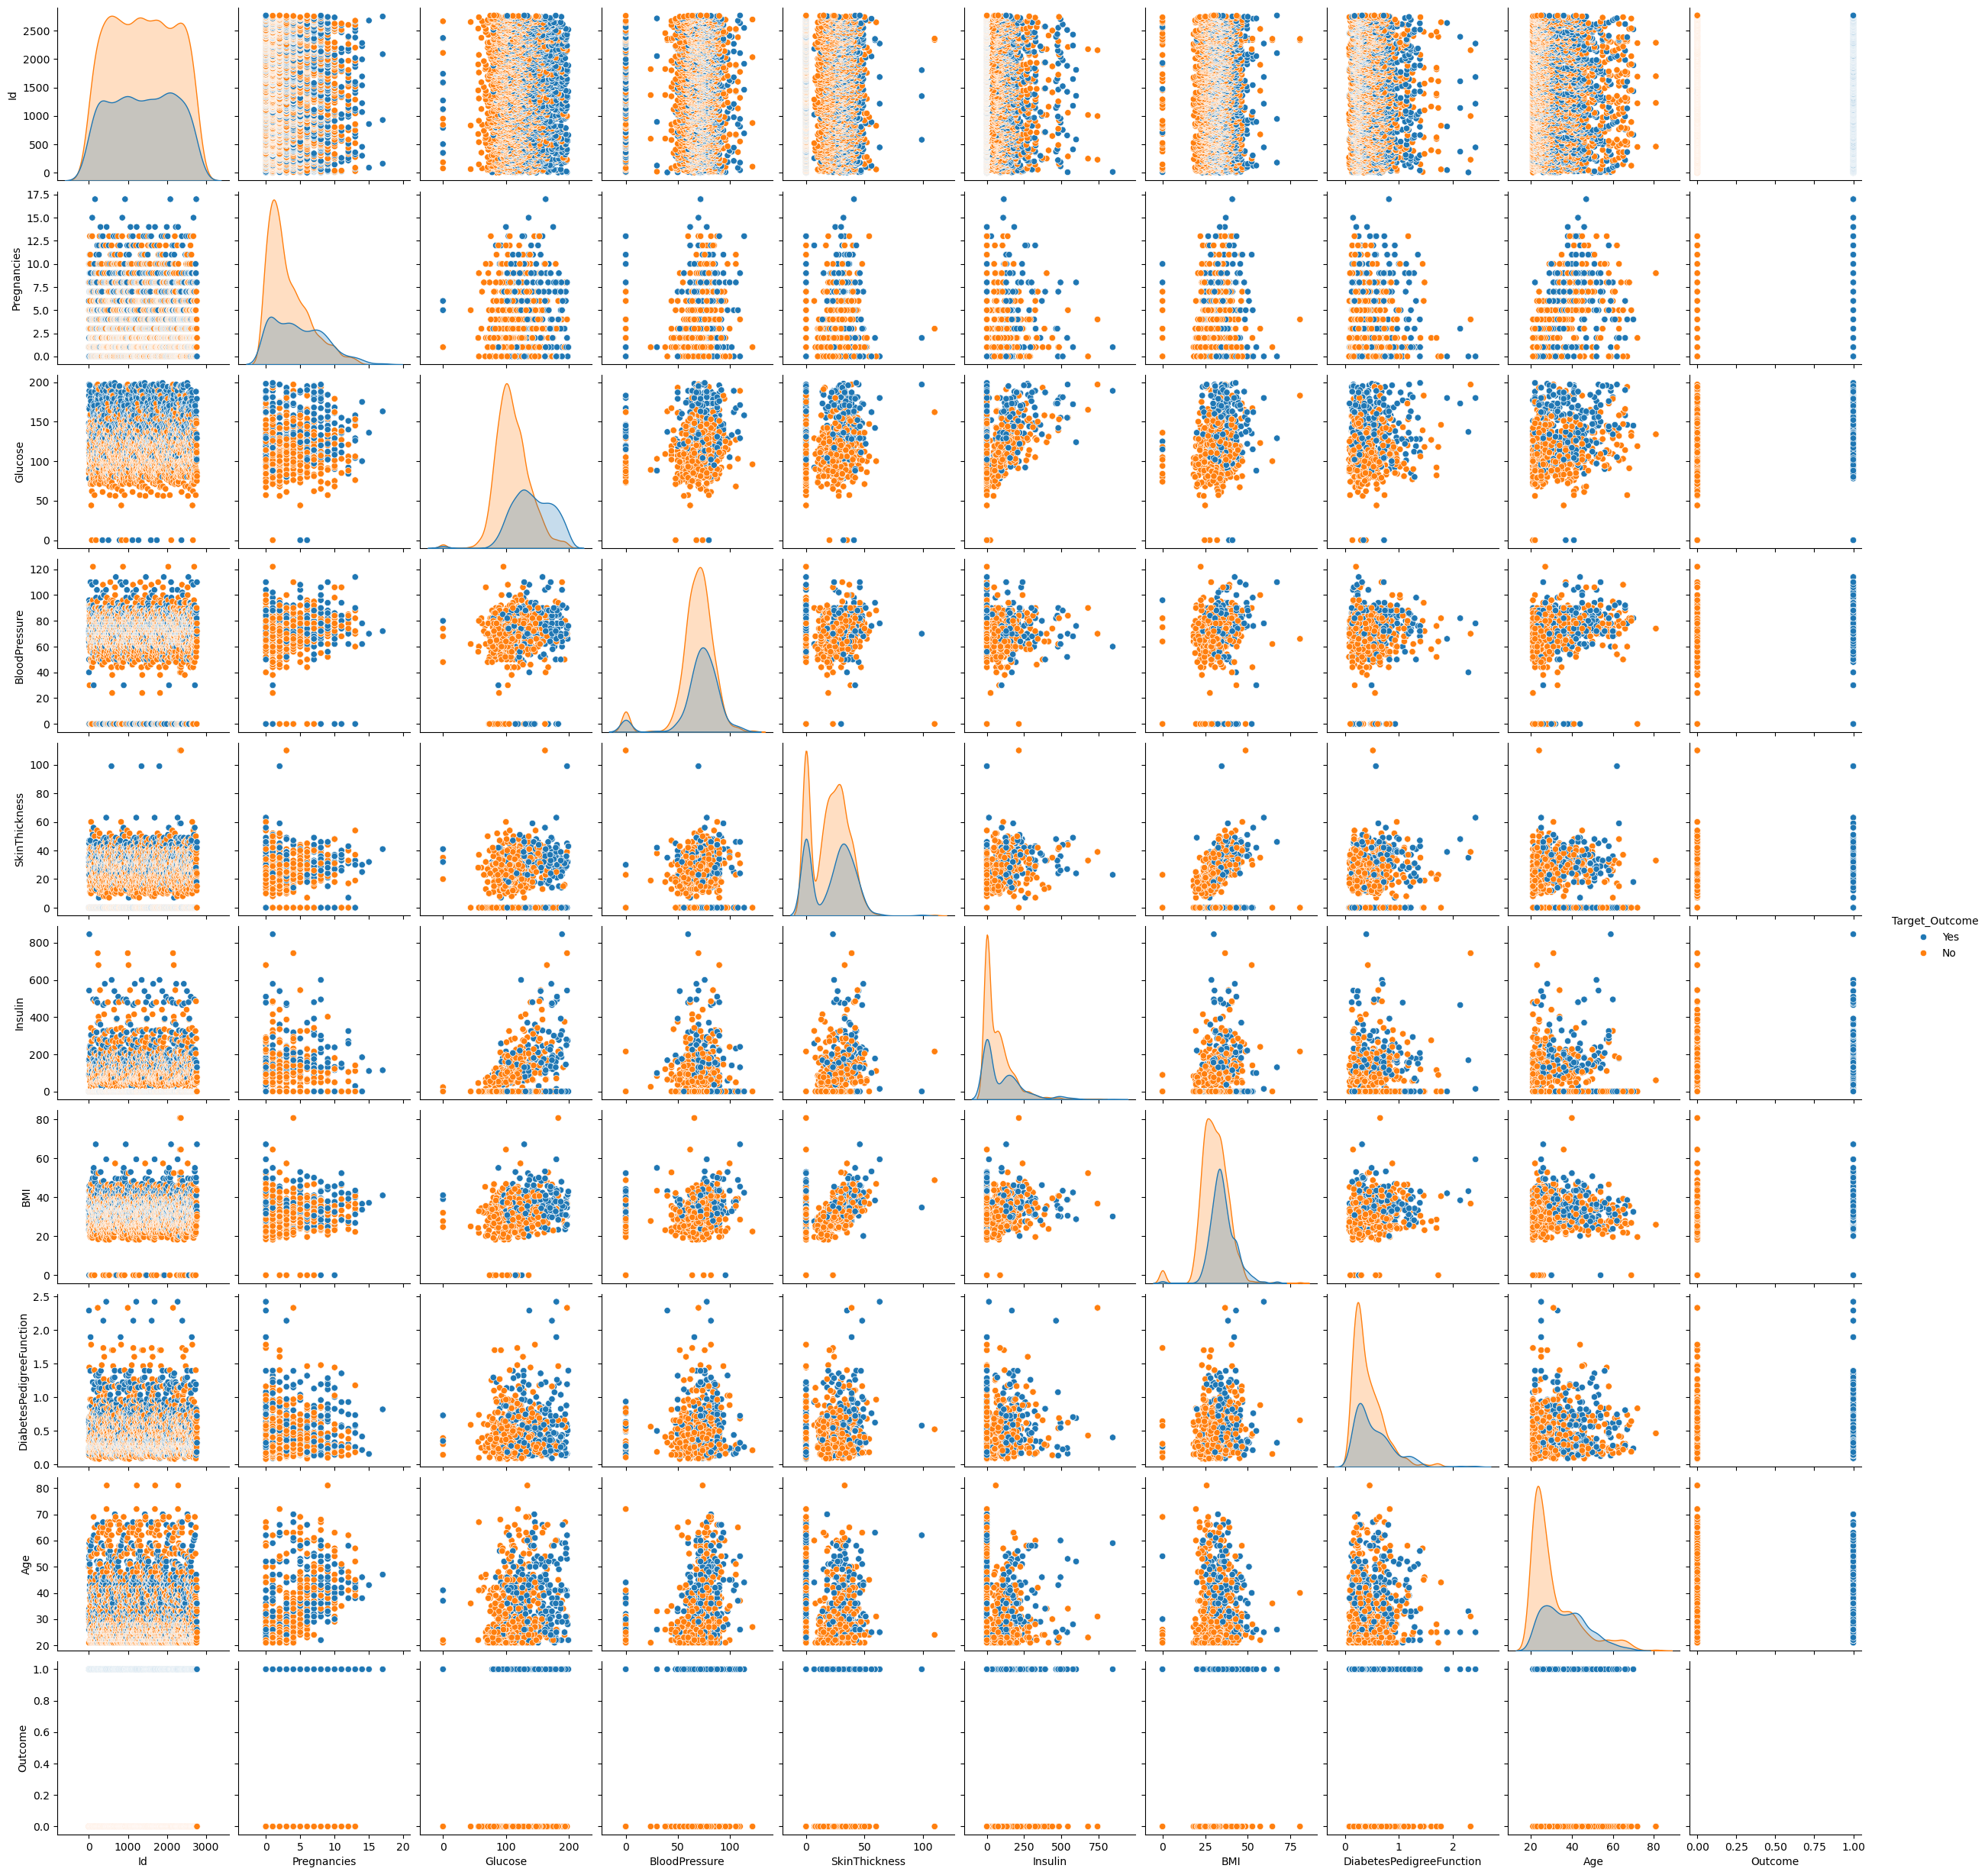

In [55]:
sns.pairplot(data, hue=('Target_Outcome'))

In [56]:
data.head(2)

Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   

   DiabetesPedigreeFunction  Age  Outcome Target_Outcome    Age_Group  \
0                     0.627   50        1            Yes  Adult(<=55)   
1                     0.351   31        0             No  Adult(<=55)   

       BP_Range  
0  Less than 80  
1  Less than 80

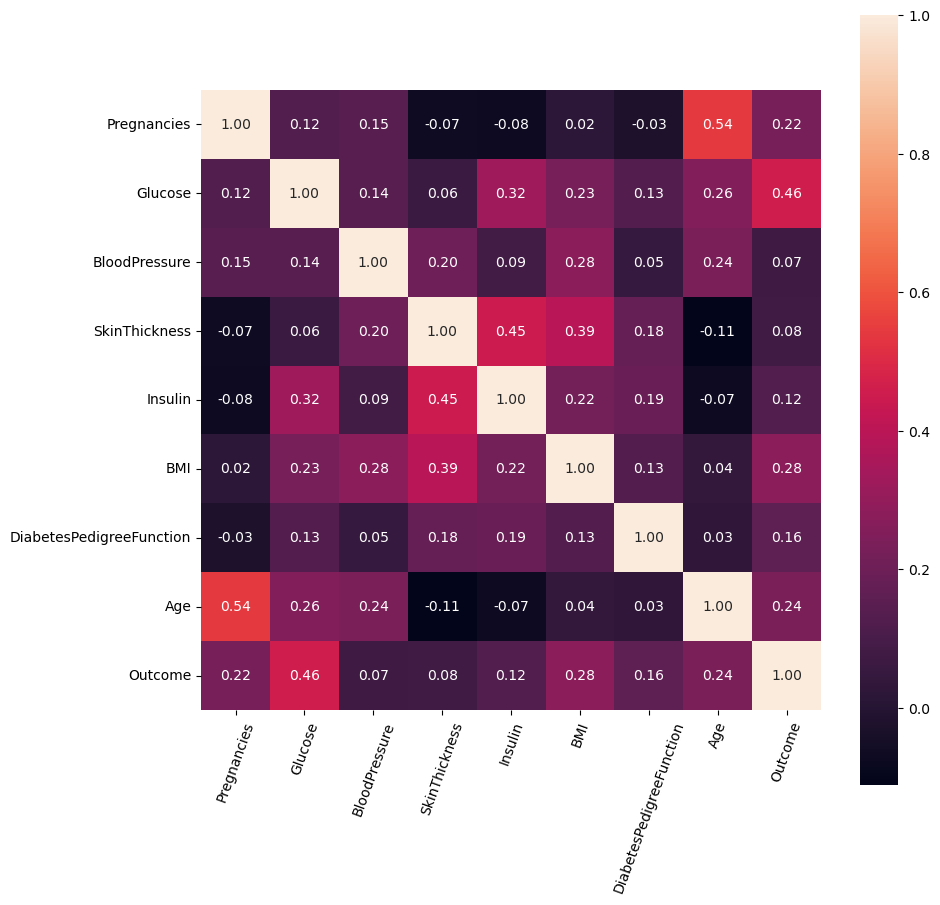

In [57]:
data = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']]
plt.figure(figsize=(10,10))
hm = sns.heatmap(data.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10})
plt.xticks(rotation=70)
plt.show()

In [58]:
#Drop the target variable
Label = data.pop('Outcome')

In [59]:
Label.head(5)

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [60]:
# Split dataset to trainig and evalustion subsets
x_train, x_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=360)

scaler = MinMaxScaler()

num_var1 = x_train.select_dtypes(include=["int64", "float64"])
num_var2 = x_test.select_dtypes(include=["int64", "float64"])

scaled_x_train = pd.DataFrame(scaler.fit_transform(num_var1), columns=data.columns)
scaled_x_test = pd.DataFrame(scaler.transform(num_var2), columns=data.columns)

with open('numd_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [61]:
scaled_x_train.head(5)

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.294118  0.633166       0.639344       0.245455  0.026005  0.367246   
1     0.470588  0.758794       0.639344       0.290909  0.248227  0.532258   
2     0.235294  0.773869       0.590164       0.263636  0.148936  0.388337   
3     0.529412  0.703518       0.770492       0.000000  0.000000  0.405707   
4     0.000000  0.507538       0.524590       0.154545  0.000000  0.260546   

   DiabetesPedigreeFunction       Age  
0                  0.154142  0.316667  
1                  0.187020  0.250000  
2                  0.111016  0.266667  
3                  0.280102  0.400000  
4                  0.074295  0.000000

### MODEL BUILDING AND EVALUATION

In [63]:
x=data
y=Label

In [64]:
# Assign each model to a variable
log_reg = LogisticRegression(max_iter=1000)
ran_for = RandomForestClassifier()
xgb = XGBClassifier(eval_metric='mlogloss')
svc = SVC(probability=True)
dec_tr = DecisionTreeClassifier()
bagging = BaggingClassifier()

# Store them in a dictionary if you need to access them by name
models = {
    'Logistic Regression': log_reg,
    'Random Forest': ran_for,
    'XGBoost': xgb,
    'Support Vector Machine': svc,
    'Decision Tree': dec_tr,
    'Bagging': bagging
}

In [65]:
# Dictionary to store results
results = {}

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1816
           1       0.49      0.54      0.51       952

    accuracy                           0.65      2768
   macro avg       0.62      0.62      0.62      2768
weighted avg       0.66      0.65      0.65      2768



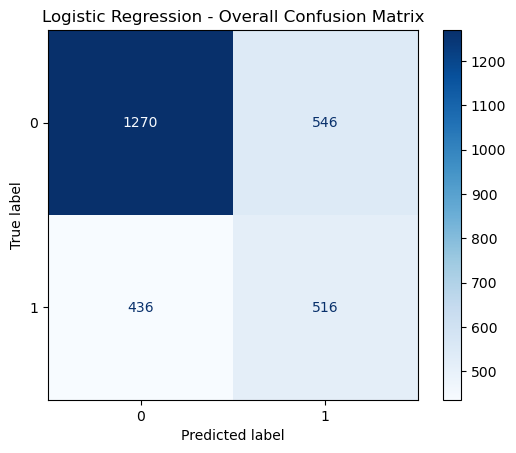

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1816
           1       0.72      0.57      0.64       952

    accuracy                           0.78      2768
   macro avg       0.76      0.73      0.74      2768
weighted avg       0.77      0.78      0.77      2768



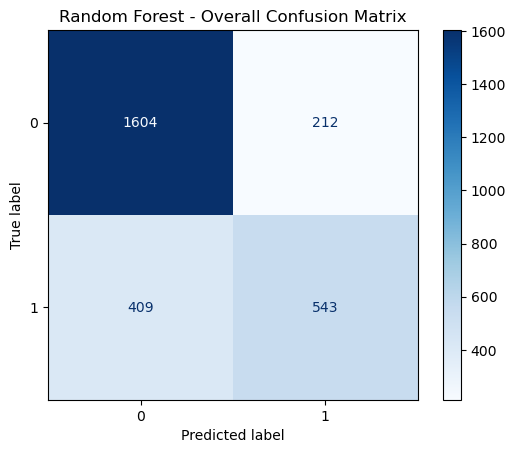

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1816
           1       0.71      0.57      0.64       952

    accuracy                           0.77      2768
   macro avg       0.75      0.73      0.74      2768
weighted avg       0.77      0.77      0.77      2768



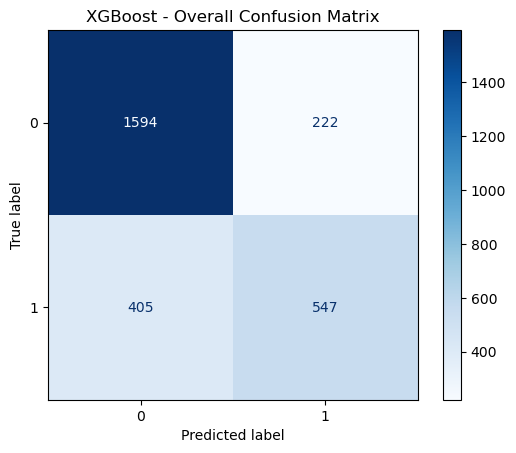

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.78      0.68      0.72      1816
           1       0.51      0.63      0.56       952

    accuracy                           0.66      2768
   macro avg       0.64      0.65      0.64      2768
weighted avg       0.68      0.66      0.67      2768



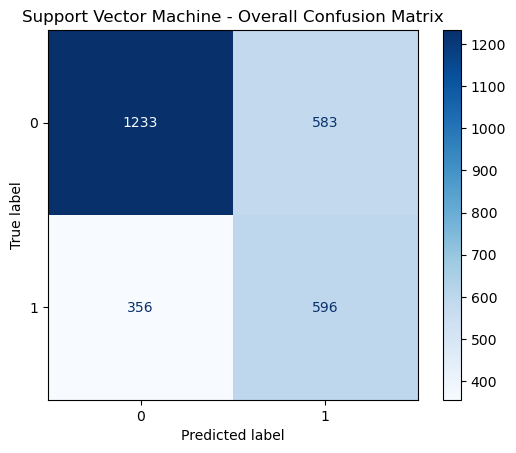

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1816
           1       0.72      0.54      0.62       952

    accuracy                           0.77      2768
   macro avg       0.75      0.71      0.73      2768
weighted avg       0.76      0.77      0.76      2768



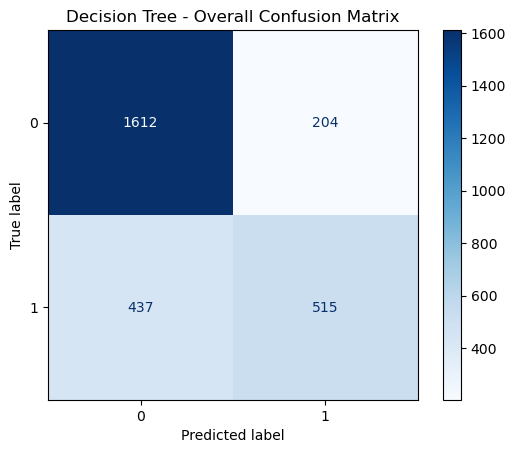

Classification Report for Bagging:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1816
           1       0.70      0.55      0.62       952

    accuracy                           0.76      2768
   macro avg       0.74      0.71      0.72      2768
weighted avg       0.76      0.76      0.76      2768



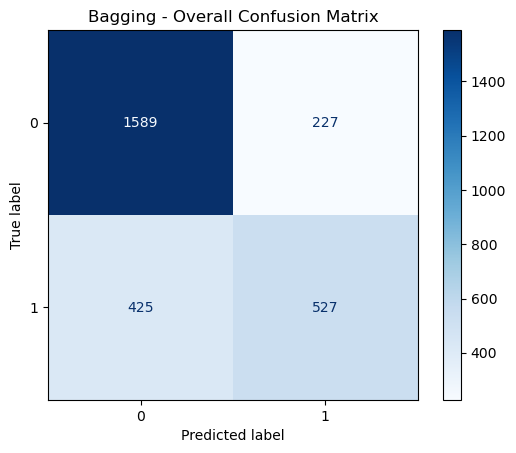

In [66]:
# Function to handle data imbalance, overfitting and numerical features normalization

# Initialize SMOTE
smote = SMOTE()

# Initialize cross-validation
cv = StratifiedKFold(n_splits=5)

for model_name, model in models.items():
    # Create a pipeline with SMOTE and the model
    pipeline = Pipeline([('smote', smote), ('model', model)])
    
    # Lists to store all true labels and predictions across folds
    all_true_labels = []
    all_predictions = []
    
    # Perform cross-validation
    for train_index, val_index in cv.split(x, y):
        x_train_cv, x_val_cv = x.iloc[train_index], x.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
        
        # Select numerical columns for scaling
        num_var1 = x_train_cv.select_dtypes(include=["int64", "float64"])
        num_var2 = x_val_cv.select_dtypes(include=["int64", "float64"])
        
        # Initialize the MinMaxScaler
        scaler = MinMaxScaler()
        
        # Scale the training and validation data
        scaled_x_train = pd.DataFrame(scaler.fit_transform(num_var1), columns=x_train_cv.columns)
        scaled_x_val = pd.DataFrame(scaler.transform(num_var2), columns=x_val_cv.columns)
        
        # Replace numerical columns in original x_train and x_val with scaled data
        x_train_cv.update(scaled_x_train)
        x_val_cv.update(scaled_x_val)
        
        # Fit the model
        pipeline.fit(x_train_cv, y_train_cv)
        
        # Predict and evaluate the model
        y_pred = pipeline.predict(x_val_cv)
        
        # Collect true labels and predictions
        all_true_labels.extend(y_val_cv)
        all_predictions.extend(y_pred)
    
    # Store classification report for the model
    report = classification_report(all_true_labels, all_predictions, output_dict=True)
    results[model_name] = {
        'classification_report': report
    }

      # Print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(all_true_labels, all_predictions))

    
    # Compute confusion matrix using all validation predictions
    cm = confusion_matrix(all_true_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot the confusion matrix
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} - Overall Confusion Matrix')
    plt.show()

### HYPERPARAMETER TUNING

In [68]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],         
    'n_estimators': [100, 200, 300],             
    'max_depth': [3, 4, 5, 6],                  
    'min_child_weight': [1, 5, 10],              
    'subsample': [0.8, 0.9, 1.0],                
    'colsample_bytree': [0.8, 0.9, 1.0],         
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Perform GridSearchCV
grid_search.fit(x_train_cv, y_train_cv)  # Fit the model with training data

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the model on the test set
tuned_xgb = grid_search.best_estimator_
y_pred = tuned_xgb.predict(x_val_cv)

# Print evaluation metrics
print("Test Accuracy: {:.2f}".format(accuracy_score(y_val_cv, y_pred)))
print("Classification Report:\n", classification_report(y_val_cv, y_pred))

Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation score: 1.00
Test Accuracy: 0.66
Classification Report:
               precision    recall  f1-score   support

           0       0.66      1.00      0.79       363
           1       1.00      0.01      0.01       190

    accuracy                           0.66       553
   macro avg       0.83      0.50      0.40       553
weighted avg       0.78      0.66      0.52       553



In [69]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dec_tr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Perform GridSearchCV
grid_search.fit(x_train_cv, y_train_cv)  # Fit the model with training data

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the model on the test set
tuned_dec = grid_search.best_estimator_
y_pred = tuned_dec.predict(x_val_cv)

# Print evaluation metrics
print("Test Accuracy: {:.2f}".format(accuracy_score(y_val_cv, y_pred)))
print("Classification Report:\n", classification_report(y_val_cv, y_pred))

Best parameters found:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.99
Test Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.98      0.78       363
           1       0.36      0.03      0.05       190

    accuracy                           0.65       553
   macro avg       0.51      0.50      0.42       553
weighted avg       0.55      0.65      0.53       553



### SAVE BEST PERFORMING MODEL

In [71]:
with open('xgb.pkl', 'wb') as file:
    pickle.dump(xgb, file)

In [72]:
with open("numd_scaler.pkl", "rb") as file:
    scaler = pickle.load(file)

with open("xgb.pkl", "rb") as file:
    model = pickle.load(file)

def transform_data(data):
    num_var = data.select_dtypes(include = ["int64", "float64"])

# Scale numerical entries
    scaled_data = pd.DataFrame(scaler.fit_transform(num_var), columns=data.columns)
    
    return scaled_data

### FEATURE IMPORTANCE

In [74]:
from xgboost import plot_importance

booster = xgb.get_booster()

In [75]:
# Get importance scores for features based on gain
importance_dict = booster.get_score(importance_type='gain')

# Print the importance scores
for feature, score in importance_dict.items():
    print('**Feature Importance using Gain Metric**:')
    print(f"Feature: {feature}, Score: {score}")

**Feature Importance using Gain Metric**:
Feature: Pregnancies, Score: 2.4027726650238037
**Feature Importance using Gain Metric**:
Feature: Glucose, Score: 5.705992221832275
**Feature Importance using Gain Metric**:
Feature: BloodPressure, Score: 2.065981149673462
**Feature Importance using Gain Metric**:
Feature: SkinThickness, Score: 2.7761390209198
**Feature Importance using Gain Metric**:
Feature: Insulin, Score: 2.899669647216797
**Feature Importance using Gain Metric**:
Feature: BMI, Score: 4.040268421173096
**Feature Importance using Gain Metric**:
Feature: DiabetesPedigreeFunction, Score: 2.37355375289917
**Feature Importance using Gain Metric**:
Feature: Age, Score: 3.303206205368042


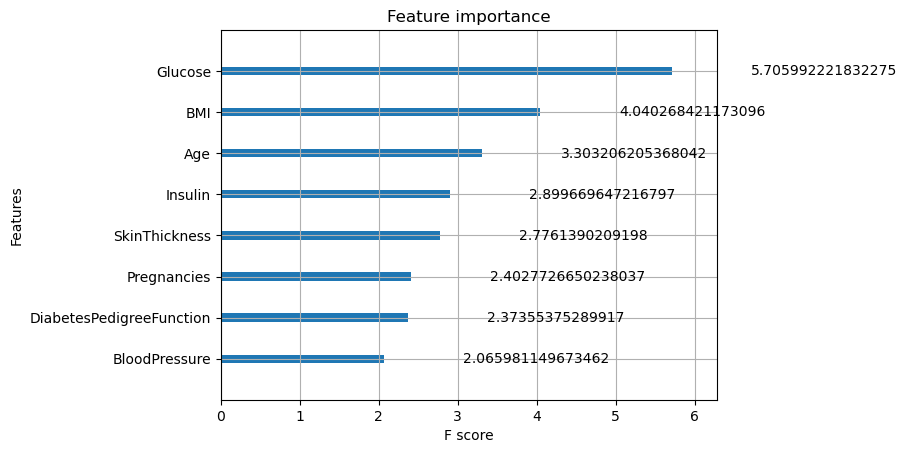

In [76]:
plot_importance(booster, importance_type='gain') 
plt.show()

##### Feature Importance (XGBoost Model)
The feature importance for the XGBoost model was determined using the **"gain" metric**, which reflects how much each feature improves the performance of splits in the decision trees.

The top most important features were:

- **Glucose:** Showed the highest importance, making significant contributions in predicting the target variable.
- **BMI:** Ranked second in importance, indicating its strong influence on the predictions.
- **Age:** Also played an important role in predicting the outcome.
- **Insulin**, **DiabetesPedigreeFunction** and **SkinThickness**, contributed moderately to the model's performance, though they had lower importance compared to the top features.
- **Pregnancies** and **BloodPressure** though contributed to the model, there importances were lower than other key features.ficant for the model.